In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.naive_bayes import ComplementNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/vlado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Classify news with Standard Machine Learning

We labelled manually about 250 news/comments. This is obviously not even close to enough but it will allow us to run a basic model like Naive Bayes and then use this model to label some more news/labels, then check some of them, add the additional data and train and so on.

In [3]:
df = pd.read_csv('hn_topic_labelling.csv', header=None)
df.columns = ['index', 'text', 'a', 'b', 'label']
df = df.dropna()
df.shape

(259, 5)

In [4]:
df

,index,text,a,b,label
0,51,I am a middle schooler and I created this libr...,technology,entertainment,AI/Data Science
1,374,"&gt;I&#x27;ve seen a grown man, extremely well...",science,science,AI/Data Science
2,375,"As a FB marketing expert, this wouldn&#x27;t w...",entertainment,world,AI/Data Science
3,114,"Um, we could stop doing gain-of-function resea...",science,science,AI/Data Science
4,90,I see a general trend in academia to include m...,science,world,AI/Data Science
...,...,...,...,...,...
254,128,"Every time I log in, ebay bugs me to confirm m...",technology,technology,web/mobile
255,127,"This feature is built upon user-specific URLs,...",technology,technology,web/mobile
256,460,"There already is a future without passwords, i...",technology,science,web/mobile
257,640,I use 1Password and it offers dedicated 2FA fi...,technology,world,web/mobile


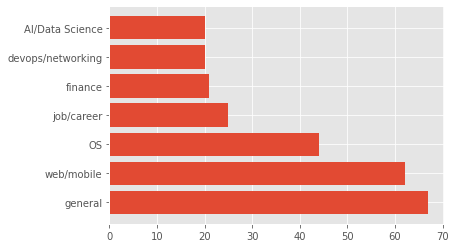

In [5]:
plt.figure(figsize=[6,4])
plt.barh(df['label'].value_counts().index, df['label'].value_counts());

In [6]:
# balanced_df = pd.DataFrame()
# for val in df['label'].unique():
#     balanced_df = balanced_df.append(df[df['label'] == val].sample(20))
# balanced_df

In [7]:
# plt.figure(figsize=[6,4])
# plt.barh(balanced_df['label'].value_counts().index, balanced_df['label'].value_counts());

We are going to have to clean the junk out of the text.

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = text.strip(' ')
    return text

def remove_stopwords(row):
    final_row = [w for w in row.split(' ') if w not in stopwords.words('english')]
    final_row = ' '.join(final_row)
    return final_row


In [9]:
df['text'] = df['text'].map(clean_text)
df['text'] = df['text'].map(remove_stopwords)

In [10]:
df

,index,text,a,b,label
0,51,middle schooler created library make extremely...,technology,entertainment,AI/Data Science
1,374,gt x seen grown man extremely well educated da...,science,science,AI/Data Science
2,375,fb marketing expert x work yes could target ma...,entertainment,world,AI/Data Science
3,114,um could stop gain function research one would...,science,science,AI/Data Science
4,90,see general trend academia include machine lea...,science,world,AI/Data Science
...,...,...,...,...,...
254,128,every time log ebay bugs confirm phone number ...,technology,technology,web/mobile
255,127,feature built upon user specific urls zelle un...,technology,technology,web/mobile
256,460,already future without passwords x webauthn p ...,technology,science,web/mobile
257,640,use password offers dedicated fa fields put co...,technology,world,web/mobile


## Tf-IDF

Here we use Tf IDf which is a method based mainly on the frequency of the words. It's very good with the simpler models that we will be creating  here. 

In [11]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df['text'])

In [12]:
x_train = x_train.toarray()

In [13]:
df['label'].unique()

array(['AI/Data Science', 'devops/networking', 'finance', 'general',
       'job/career', 'OS', 'web/mobile'], dtype=object)

In [14]:
df['label'] = df['label'].map({'AI/Data Science': 0, 'devops/networking': 1, 'finance': 2, 'general': 3, 'job/career': 4, 'OS': 5, 'web/mobile': 6})
y_train = df['label'] 

In [15]:
x_train.shape, y_train.shape

((259, 4242), (259,))

## Oversampling 

This oversampler use distances to artificially generate more data. This is something that we desperately need to perform.

In [16]:
oversample = RandomOverSampler({0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250})
x_train, y_train = oversample.fit_resample(x_train, y_train)

/home/vlado/anaconda3/envs/ml/lib/python3.8/site-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy={0: 250, 1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250} as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
/home/vlado/anaconda3/envs/ml/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (250) in class 0 will be larger than the number of samples in the majority class (class #3 -> 67)
  warnings.warn(
/home/vlado/anaconda3/envs/ml/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (250) in class 1 will be larger than the number of samples in the majority class (class #3 -> 67)
  warnings.warn(
/home/vlado/anaconda3/envs/ml/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (250) in class 2 will 

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [18]:
x_train.shape, y_train.shape

((1312, 4242), (1312,))

In [19]:
x_test.shape, y_test.shape

((438, 4242), (438,))

## Naive Bayes

Very good with text data, sparse matrices and tf-idf.

In [20]:
nb = ComplementNB()

In [21]:
nb.fit(x_train, y_train)

ComplementNB()

In [22]:
preds = nb.predict(x_test)

In [23]:
def print_metrics(model, predictions):
    print(f'Train Accuracy: {model.score(x_train, y_train)}')
    print(f'Test Accuracy: {model.score(x_test, y_test)}')
    print(f'F1 score: {f1_score(predictions, y_test, average = "weighted")}')

In [24]:
print_metrics(nb, preds)

Train Accuracy: 0.9946646341463414
Test Accuracy: 0.9611872146118722
F1 score: 0.961959124867701


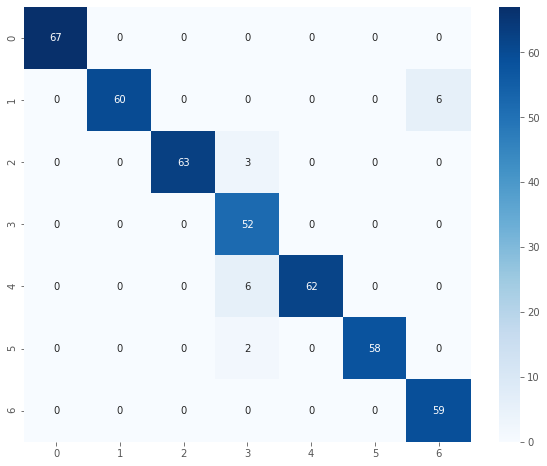

In [25]:
def show_confusion_matrix(predictions):
    conf_matrix = confusion_matrix(predictions, y_test)
    plt.figure(figsize=[10,8])
    sns.heatmap(conf_matrix, annot = True, fmt ='d',cmap = 'Blues');

show_confusion_matrix(preds)

## Save model

Let's create a pipeline that will ease the model when serves in production.

In [27]:
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])
pipe.fit(df['text'] , df['label'] )

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])

In [31]:
def test_with_random_text(txt):
    txt = clean_text(txt)
    txt = remove_stopwords(txt)
    pred = pipe.predict([txt])
    return pred

In [32]:
pred = test_with_random_text('Windows is the worst OS there is. I hope people will soon see the excelence of Linux')
pred

array([5])

In [33]:
pred = test_with_random_text('This is all about politics.This is not in our labels so it should be general')
pred

array([3])

In [34]:
pred = test_with_random_text('AWS is the first cloud provider that i can think of. The label should be one')
pred

array([1])

In [35]:
import pickle
save_classifier = open("nb_topic_classifier.pickle","wb")
pickle.dump(pipe, save_classifier)
save_classifier.close()

## Label the NULL data

In [36]:
df = pd.read_csv('hn_topic_labelling.csv', header=None)
df.columns = ['index', 'text', 'a', 'b', 'label']

In [37]:
target = df[df['label'].isnull()]
target = target[['text', 'label']]

In [38]:
target['text'] = target['text'].map(clean_text)
target['text'] = target['text'].map(remove_stopwords)

In [39]:
target

,text,label
259,scale environmentally friendly organic grass f...,NaN
260,x worked different teams startups target tell ...,NaN
261,x,NaN
262,human evolution poorly understood assumption c...,NaN
263,woulda given away p username checks,NaN
...,...,...
1982,might prove difficult endeavour foundries desi...,NaN
1983,certain topics get reliable readers despite tr...,NaN
1984,gt even marriage depends school share marriage...,NaN
1985,english x p french italian german though alrea...,NaN


In [40]:
MAPPING_DICT = {0: 'AI/Data Science', 1: 'devops/networking', 2: 'finance', 3: 'general', 4: 'job/career', 5: 'OS',6: 'web/mobile'}
preds = pipe.predict(target['text'])
preds = [MAPPING_DICT[i] for i in preds]

In [41]:
for i in range(len(target.index)):
    target['label'].loc[target.index[i]] = preds[i] 

In [44]:
target

,text,label
259,scale environmentally friendly organic grass f...,finance
260,x worked different teams startups target tell ...,web/mobile
261,x,AI/Data Science
262,human evolution poorly understood assumption c...,general
263,woulda given away p username checks,devops/networking
...,...,...
1982,might prove difficult endeavour foundries desi...,web/mobile
1983,certain topics get reliable readers despite tr...,web/mobile
1984,gt even marriage depends school share marriage...,general
1985,english x p french italian german though alrea...,general
